<center>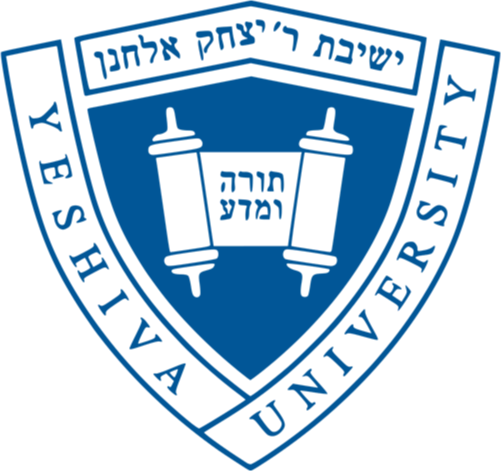</center>

<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5005 Machine Learning</h1>
<p>
<h2 style='text-align: center;'>Final Project</h1>
<br><br>
<h2 style='text-align: center;'>Listen to the Birds: A Convolutional Neural Network Approach for Bird Species Identification</h1>
<br><br>

<div style="display: flex; justify-content: center;">
    <table style="border-collapse: collapse; border: 0;">
        <tr>
            <td style="text-align:center; vertical-align:middle; padding:10px 40px 10px 10px; border: 0;">
                <h3 style="margin: 0;">Sheng-Han Yueh</h3>
            </td>
            <td style="text-align:center; vertical-align:middle; padding:10px 10px 10px 40px; border: 0;">
                <h3 style="margin: 0;">Radek Jan Holik</h3>
            </td>
        </tr>
    </table>
</div>
<br>
<br>
<br>

# __Package Import__

In [11]:
import platform
import os
import sys
import random
import librosa
import numpy as np
np.set_printoptions(threshold = sys.maxsize)

import math
import pandas as pd

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.transforms import Compose
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict

import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 250
# plt.rcParams['savefig.dpi'] = 250
from IPython.display import set_matplotlib_formats
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatch
import seaborn as sns
import collections
from PIL import Image

from datetime import datetime, timedelta
from timeit import default_timer as timer

import pickle

from IPython.display import clear_output

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import SwishImplementation
from efficientnet_pytorch.utils import MemoryEfficientSwish
from torchvision.models import resnet101
from torchvision.models import googlenet

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, label_binarize

import warnings
warnings.filterwarnings("ignore")

In [12]:
#! pip install efficientnet_pytorch

In [13]:
print(f"Python Version : {platform.python_version()}")
print(f"PyTorch Version : {torch.__version__}")
print(f"CUDA Version : {torch.version.cuda}")
print(f"torchaudio.__version__ : {torchaudio.__version__}")

print()

if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  print(f"Number of CUDA devices : {torch.cuda.device_count()}")
  print(f"Device name : {torch.cuda.get_device_name(0)}")
  device = "cuda:0"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

Python Version : 3.10.11
PyTorch Version : 2.0.1+cu118
CUDA Version : 11.8
torchaudio.__version__ : 2.0.2+cu118

CUDA available. Using GPU acceleration.
Number of CUDA devices : 1
Device name : NVIDIA GeForce RTX 4090


# __Data Preparation__

## __Sample Example__

In [14]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize = (8, 5))
    if num_channels == 1:
        axes = [axes]

    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth = 1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c + 1}")
    # plt.savefig("wave_form.svg")
    figure.suptitle("Wave Form")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(linestyle='--', linewidth = 0.5)
    plt.show(block = False)

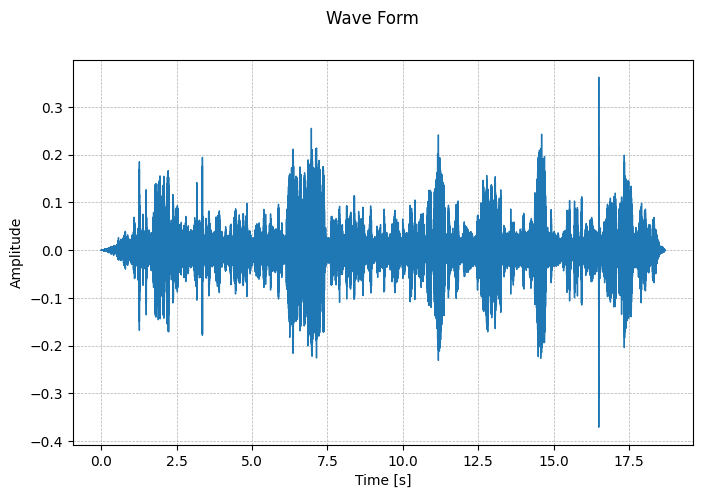

In [15]:
sound, sample_rate = torchaudio.load(r'birdclef-2023/train_audio/abethr1/XC363501.ogg')
plot_waveform(sound, sample_rate)

In [17]:
print(f"sound.size() : {sound.size()}")
print(f"sample_rate : {sample_rate}")

sound.size() : torch.Size([1, 597682])
sample_rate : 32000


## __Data Set__

In [18]:
def prepare_file_and_label_lists(root_dir):
    file_list = []
    label_list = []
    
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        
        if os.path.isdir(label_dir):
            for audio_file in os.listdir(label_dir):
                if audio_file.endswith('.ogg'):
                    file_list.append(os.path.join(label_dir, audio_file))
                    label_list.append(label)
                    
    return file_list, label_list

In [19]:
class BirdSoundDataset(Dataset):
    def __init__(self, audio_files, labels, mel_spectrogram_transform, transform = None, segment_length = 5):
        self.audio_files = audio_files
        self.labels = labels
        self.mel_spectrogram_transform = mel_spectrogram_transform
        self.transform = transform
        self.segment_length = segment_length

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, index):
        audio_file = self.audio_files[index]
        label = self.labels[index]

        spectrograms = self.audio_to_spectrograms(audio_file)
        spectrograms_norm = [self.norm_spectrogram(spectrogram) for spectrogram in spectrograms]
        return spectrograms_norm, label
    
    def norm_spectrogram(self, spectrogram):
        # Normalize the spectrogram to the range [0, 1]
        spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
        
        return spectrogram
    
    def add_noise(self, audio, noise_factor = 0.005):
        noise = np.random.randn(len(audio))
        audio_noise = audio + noise_factor * noise
        return np.clip(audio_noise, -1, 1)

    def audio_to_spectrograms(self, audio_file):
        y, sr = librosa.load(audio_file, sr = 32000)
        duration = len(y) / sr
        num_segments = math.ceil(duration / self.segment_length)

        spectrograms = []
        for i in range(num_segments):
            start = i * self.segment_length * sr
            end = start + (self.segment_length * sr)
            segment = y[start:end]

            # Add noise to the segment
            segment = self.add_noise(segment)

            # Pad the segment if it's too short
            if len(segment) < self.mel_spectrogram_transform.n_fft:
                padding = self.mel_spectrogram_transform.n_fft - len(segment)
                # segment = np.pad(segment, (0, padding), mode='constant')
                # 'wrap' for cyclic padding
                segment = np.pad(segment, (0, padding), mode = 'wrap')
            
            spectrogram = self.mel_spectrogram_transform(torch.tensor(segment).float())  # convert the tensor to float
            spectrogram = librosa.power_to_db(spectrogram.numpy(), ref = np.max)
            spectrograms.append(spectrogram)

        return spectrograms
    

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = 32000,
    n_fft = 2048,
    hop_length = (5 * 32000 - 2048) // (256 - 1),
    n_mels = 128,
    f_min = 300,
    f_max = 15000,
    center = False)

## __Training Data__

### Creating the dataset

In [20]:
# Get audio files and labels
root_dir = './birdclef-2023/train_audio/'
file_list, label_list = prepare_file_and_label_lists(root_dir)

In [21]:
print(f"Length of file_list : {len(file_list):,}")
print(f"Length of label_list : {len(label_list):,}")

Length of file_list : 16,961
Length of label_list : 16,961


In [22]:
bird_sound_dataset = BirdSoundDataset(file_list, label_list, mel_spectrogram)

In [23]:
print(f"Length of bird_sound_dataset : {len(bird_sound_dataset):,}")

Length of bird_sound_dataset : 16,961


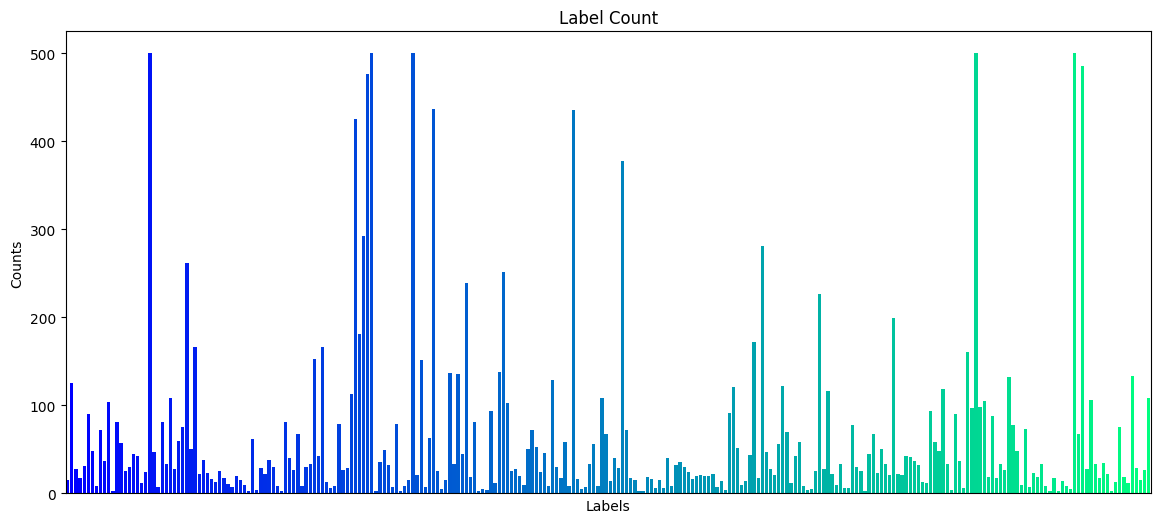

In [24]:
# Count the occurrences of each label
label_counts = collections.Counter(label_list)

# Get the unique labels and their corresponding counts
labels, counts = zip(*label_counts.items())

# Generate a color sequence
colors = plt.cm.winter(np.linspace(0, 1, len(labels)))

# Plot the label density
plt.figure(figsize=(14, 6))
plt.bar(labels, counts, color = colors)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Label Count")
# Set x-axis labels to be vertically aligned and use a smaller font size
plt.xticks(rotation = 90, fontsize = 4)
plt.xticks([])
# Adjust the x-axis limits
plt.xlim(-0.5, len(labels)-0.5)
plt.show()

In [25]:
print(f"Label with the lowes number of samples : {labels[list(counts).index(min(counts))]} , Number of samples : {min(counts):,}")
print(f"Label with the highest number of samples : {labels[list(counts).index(max(counts))]} , Number of samples : {max(counts):,}")

Label with the lowes number of samples : afpkin1 , Number of samples : 3
Label with the highest number of samples : barswa , Number of samples : 500


 ### Spectrogram Images and Their Corresponding Labels

In [26]:
spectrogram_list = []
corresponding_labels = []

for idx in range(len(bird_sound_dataset)):
    spectrograms, label = bird_sound_dataset[idx]
    spectrogram_list.extend(spectrograms)
    corresponding_labels.extend([label] * len(spectrograms))

### Save spectrogram_list and corresponding_labels 

In [27]:
with open("spectrogram_list.pkl", "wb") as f:
    pickle.dump(spectrogram_list, f)

with open("corresponding_labels.pkl", "wb") as f:
    pickle.dump(corresponding_labels, f)

### Load spectrogram_list and corresponding_labels }

In [28]:
with open("spectrogram_list.pkl", "rb") as f:
    spectrogram_list = pickle.load(f)

with open("corresponding_labels.pkl", "rb") as f:
    corresponding_labels = pickle.load(f)

In [29]:
print(f"Number of samples : {len(spectrogram_list):,}")

Number of samples : 147,288


In [30]:
max_time_dim = max([spectrogram.shape[1] for spectrogram in spectrogram_list])
# print(max_time_dim)

In [31]:
def pad_spectrograms(spectrogram_list, max_time_dim):
    padded_spectrograms = []
    for spectrogram in spectrogram_list:
        padding = max_time_dim - spectrogram.shape[1]
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode = 'wrap')
        padded_spectrograms.append(padded_spectrogram)
    return padded_spectrograms

In [32]:
padded_spectrogram_list = pad_spectrograms(spectrogram_list, max_time_dim)

In [33]:
del spectrogram_list

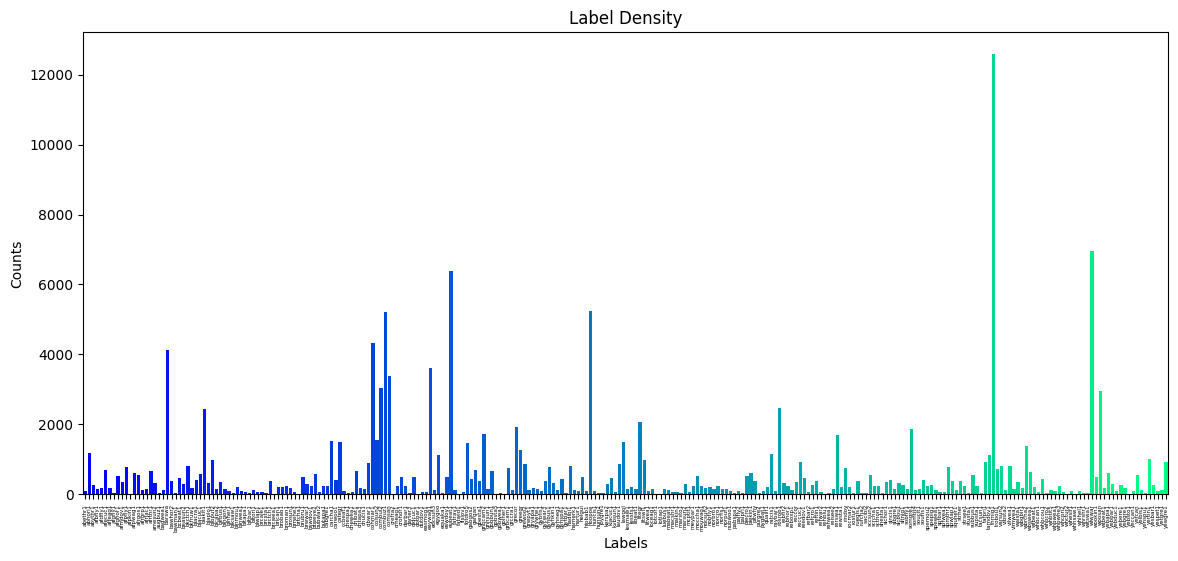

In [34]:
# Count the occurrences of each label
label_counts = collections.Counter(corresponding_labels)

# Get the unique labels and their corresponding counts
labels, counts = zip(*label_counts.items())

# Generate a color sequence
colors = plt.cm.winter(np.linspace(0, 1, len(labels)))

# Plot the label density
plt.figure(figsize=(14, 6))
plt.bar(labels, counts, color = colors)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Label Density")
# Set x-axis labels to be vertically aligned and use a smaller font size
plt.xticks(rotation = 90, fontsize = 4)
# plt.xticks([])
plt.xlim(-0.5, len(labels)-0.5)
plt.show()

In [35]:
print(f"Label with the lowes number of samples : {labels[list(counts).index(min(counts))]} , Number of samples : {min(counts):,}")
print(f"Label with the highest number of samples : {labels[list(counts).index(max(counts))]} , Number of samples : {max(counts):,}")

Label with the lowes number of samples : lotlap1 , Number of samples : 5
Label with the highest number of samples : thrnig1 , Number of samples : 12,584


### Oversampling

In [36]:
# Convert label list to encoded labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(corresponding_labels)

# Compute class weights
class_weights = 1. / np.bincount(encoded_labels)
sample_weights = class_weights[encoded_labels]


# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights = sample_weights, num_samples = len(sample_weights), replacement = True)

In [37]:
# Create a dictionary to hold your spectrograms based on their corresponding labels
spectrogram_dict = collections.defaultdict(list)

# Group your spectrograms by their labels
for spectrogram, label in zip(padded_spectrogram_list, corresponding_labels):
    spectrogram_dict[label].append(spectrogram)

# Find the maximum number of spectrograms any class has
max_len = max(len(spectrograms) for spectrograms in spectrogram_dict.values())

# Create new lists for your balanced spectrograms and labels
balanced_spectrogram_list = []
balanced_labels = []

# Duplicate spectrograms in classes with fewer instances
for label, spectrograms in spectrogram_dict.items():
    count = len(spectrograms)
    for i in range(max_len):
        balanced_spectrogram_list.append(spectrograms[i % count])  # Use modulo operation to duplicate instances
        balanced_labels.append(label)

In [38]:
print(f"Number of samples : {len(balanced_labels):,}")

Number of samples : 3,322,176


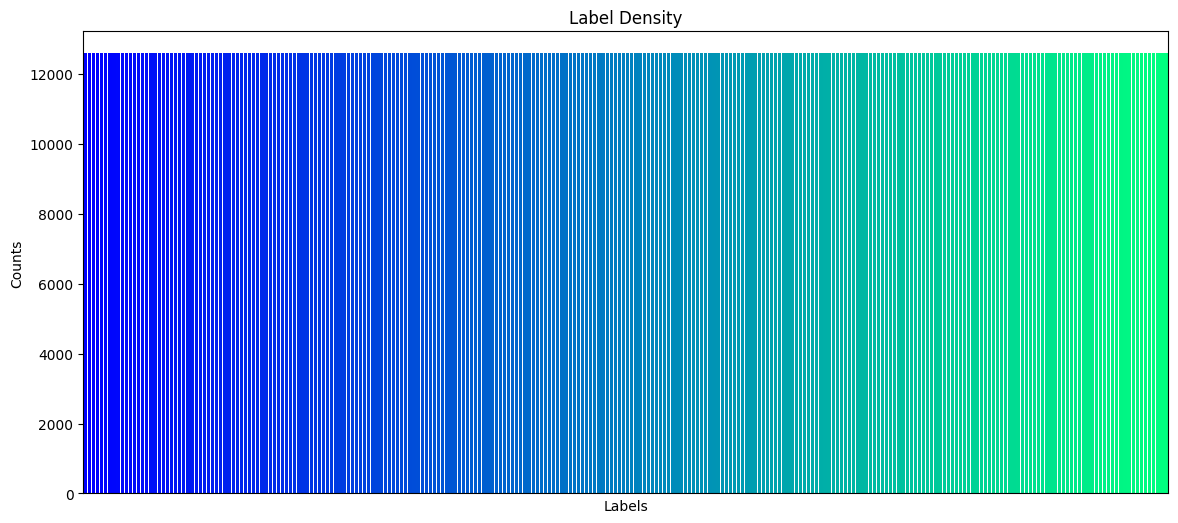

In [39]:
# Count the occurrences of each label
label_counts = collections.Counter(balanced_labels)

# Get the unique labels and their corresponding counts
labels, counts = zip(*label_counts.items())

# Generate a color sequence
colors = plt.cm.winter(np.linspace(0, 1, len(labels)))

# Plot the label density
plt.figure(figsize=(14, 6))
plt.bar(labels, counts, color = colors)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Label Density")
# Set x-axis labels to be vertically aligned and use a smaller font size
# plt.xticks(rotation = 90, fontsize = 4)
plt.xticks([])
plt.xlim(-0.5, len(labels)-0.5)
plt.show()

### __Based on the previous results, we decided NOT to use oversampling because our data set would increase more than twentyfold, which would increase the training time enormously.__

### Plot of Spectrograms

In [40]:
def plot_random_spectrograms(spectrogram_list, corresponding_labels, num_plots = 5):

    assert len(spectrogram_list) == len(corresponding_labels)
    
    indices = random.sample(range(len(spectrogram_list)), num_plots)
    
    for i in indices:
        spectrogram = spectrogram_list[i]
        label = corresponding_labels[i]
        
        fig, ax = plt.subplots(figsize=(7, 5))
        img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')

        ax.set_title(f"Label: {label}")
            
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')

        # Remove the axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
            
        plt.tight_layout()
        plt.show()

In [41]:
# spectrogram_list, corresponding_labels = balanced_spectrogram_list, balanced_labels

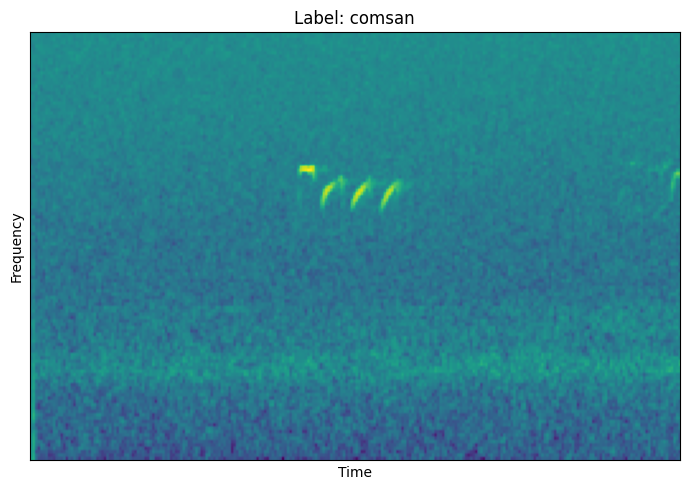

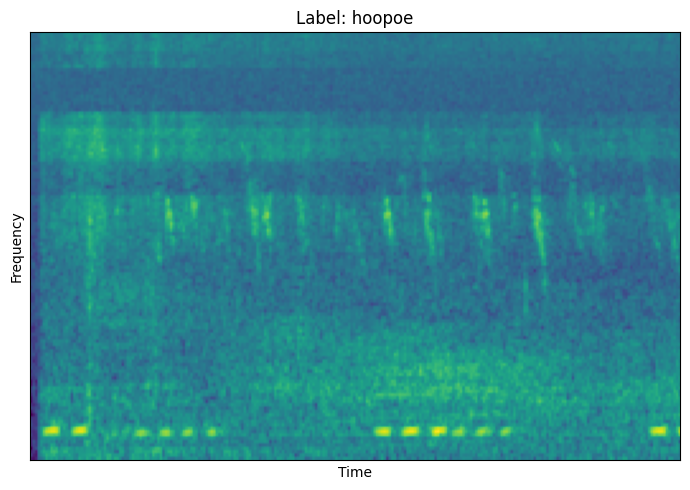

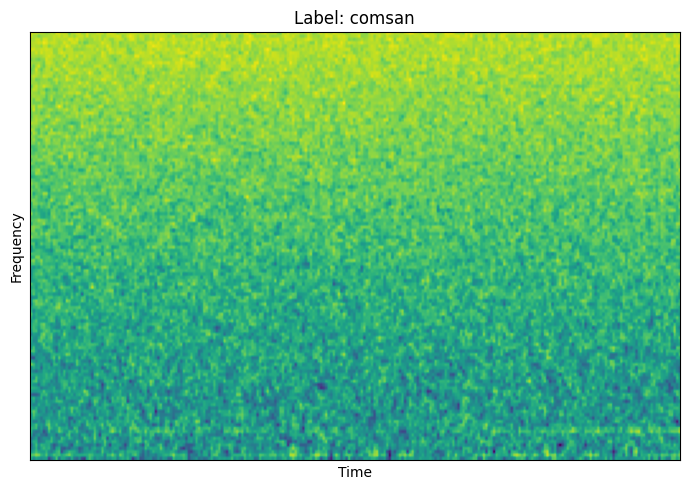

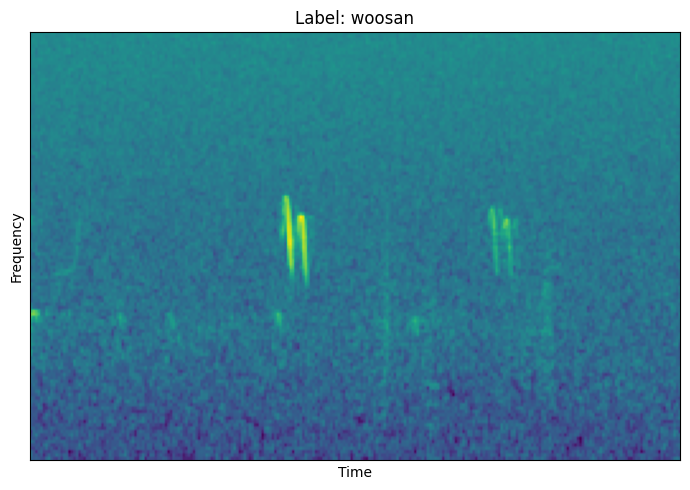

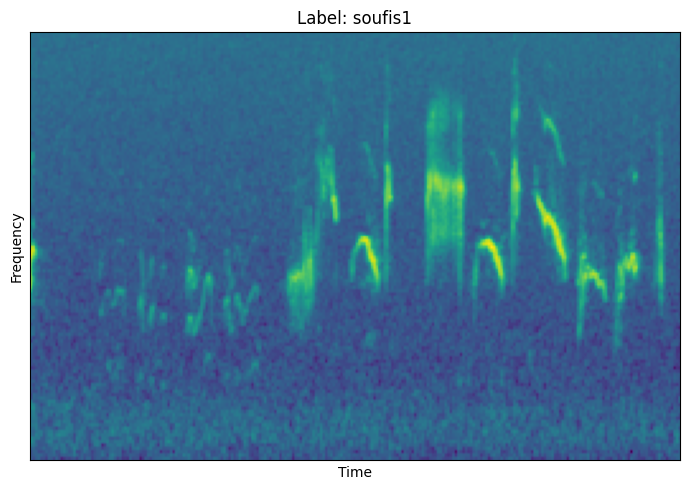

In [42]:
# Call the function with the loaded spectrogram_list and corresponding_labels
plot_random_spectrograms(padded_spectrogram_list, corresponding_labels)

### Split the data into training and validation sets

In [43]:
# Converting labels to integer 
label_encoder = LabelEncoder()
label_encoder.fit(corresponding_labels)

corresponding_labels = label_encoder.transform(corresponding_labels)

In [44]:
# Split the data into training and validation sets
spectrogram_train, spectrogram_val, label_train, label_val = train_test_split(
    padded_spectrogram_list, corresponding_labels, stratify = corresponding_labels, test_size = 0.1, random_state = 42
)

In [45]:
num_classes = len(np.unique(corresponding_labels))
print(f"Number of classes : {num_classes}")

Number of classes : 264


In [46]:
del padded_spectrogram_list
del corresponding_labels

### Convert the data to PyTorch tensors

In [47]:
# Convert the lists of numpy arrays to single numpy arrays
spectrogram_train_np = np.array(spectrogram_train)
spectrogram_val_np = np.array(spectrogram_val)

del spectrogram_train
del spectrogram_val

In [48]:
# Convert the numpy arrays to PyTorch tensors and add the channel dimension
X_train = torch.tensor(spectrogram_train_np).unsqueeze(1)
X_val = torch.tensor(spectrogram_val_np).unsqueeze(1)

del spectrogram_train_np
del spectrogram_val_np

In [49]:
# Convert the data to PyTorch tensors
y_train = torch.tensor(label_train, dtype = torch.long)
y_val = torch.tensor(label_val, dtype = torch.long)

del label_train
del label_val

In [50]:
# Create TensorDataset instances
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

del X_train
del y_train
del X_val
del y_val

### __Save/Load Datasets__

In [51]:
# Save your datasets
torch.save(train_dataset, 'train_dataset.pth')
torch.save(val_dataset, 'val_dataset.pth')

In [52]:
# Load your datasets
train_dataset = torch.load('train_dataset.pth')
val_dataset = torch.load('val_dataset.pth')

In [53]:
X_train, y_train = train_dataset.tensors

# Convert bytes to megabytes
mem_X_train = (X_train.element_size() * X_train.numel())
mem_y_train = (y_train.element_size() * y_train.numel())

print(f"Memory occupied by train_dataset : {(mem_X_train + mem_y_train) / (1024 ** 2):.2f} MB or {(mem_X_train + mem_y_train) / (1024 ** 3):.2f} GB")
# print(f"Memory occupied by y_train: {mem_y_train_MB} MB")

Memory occupied by train_dataset : 16570.89 MB or 16.18 GB


In [54]:
X_val, y_val = val_dataset.tensors

# Convert bytes to megabytes
mem_X_val = (X_val.element_size() * X_val.numel())
mem_y_val = (y_val.element_size() * y_val.numel())

print(f"Memory occupied by val_dataset : {(mem_X_val + mem_y_val) / (1024 ** 2):.2f} MB or {(mem_X_val + mem_y_val) / (1024 ** 3):.2f} GB")

Memory occupied by val_dataset : 1841.24 MB or 1.80 GB


In [55]:
print(f"The size of the entire data set : {(mem_X_train + mem_y_train + mem_X_val + mem_y_val) / (1024 ** 2):.2f} MB or {(mem_X_train + mem_y_train + mem_X_val + mem_y_val) / (1024 ** 3):.2f} GB")

The size of the entire data set : 18412.12 MB or 17.98 GB


In [56]:
num_classes =  264

### __Creation of data loaders__

In [57]:
batch_size = 48

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
# val_loader = DataLoader(val_dataset, batch_size = int(batch_size/2), shuffle = False)

In [58]:
print(f"Number of training samples : {len(train_dataset):,}")
print(f"Number of batches in train DataLoader: {len(train_loader):,}")
print()
print(f"Number of validation samples : {len(val_dataset):,}")
print(f"Number of batches in validation DataLoader: {len(val_loader):,}")
print()
print(f"Total number of samples : {len(train_dataset) + len(val_dataset):,}")

Number of training samples : 132,559
Number of batches in train DataLoader: 2,762

Number of validation samples : 14,729
Number of batches in validation DataLoader: 307

Total number of samples : 147,288


## __Testing Data__

In [59]:
class BirdSoundTestDataset(Dataset):
    def __init__(self, audio_files, mel_spectrogram_transform, transform=None, segment_length = 5):
        self.audio_files = audio_files
        self.mel_spectrogram_transform = mel_spectrogram_transform
        self.transform = transform
        self.segment_length = segment_length

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, index):
        audio_file = self.audio_files[index]

        spectrograms = self.audio_to_spectrograms(audio_file)
        spectrograms_norm = [self.norm_spectrogram(spectrogram) for spectrogram in spectrograms]
        return spectrograms_norm
    
    def norm_spectrogram(self, spectrogram):
        # Normalize the spectrogram to the range [0, 1]
        spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram))
        
        return spectrogram

    def audio_to_spectrograms(self, audio_file):
        y, sr = librosa.load(audio_file, sr = 32000)
        duration = len(y) / sr
        num_segments = math.ceil(duration / self.segment_length)

        spectrograms = []
        for i in range(num_segments):
            start = i * self.segment_length * sr
            end = start + (self.segment_length * sr)
            segment = y[start:end]

            # Pad the segment if it's too short
            if len(segment) < self.mel_spectrogram_transform.n_fft:
                padding = self.mel_spectrogram_transform.n_fft - len(segment)
                segment = np.pad(segment, (0, padding), mode = 'wrap')
            
            spectrogram = self.mel_spectrogram_transform(torch.tensor(segment).float())  # convert the tensor to float
            spectrogram = librosa.power_to_db(spectrogram.numpy(), ref = np.max)
            spectrograms.append(spectrogram)

        return spectrograms
    

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = 32000,
    n_fft = 2048,
    hop_length = (5 * 32000 - 2048) // (256 - 1),
    n_mels = 128,
    f_min = 300,
    f_max = 15000,
    center = False)

### Creating the dataset

In [60]:
# Get audio file
test_audio_files = ['./birdclef-2023/test_soundscapes/soundscape_29201.ogg']

In [61]:
# Create the test dataset
test_dataset = BirdSoundTestDataset(test_audio_files, mel_spectrogram)

In [62]:
spectrogram_list = []

for idx in range(len(test_dataset)):
    spectrograms = test_dataset[idx]
    spectrogram_list.extend(spectrograms)

In [63]:
print(f"Number of samples : {len(spectrogram_list)}")

Number of samples : 120


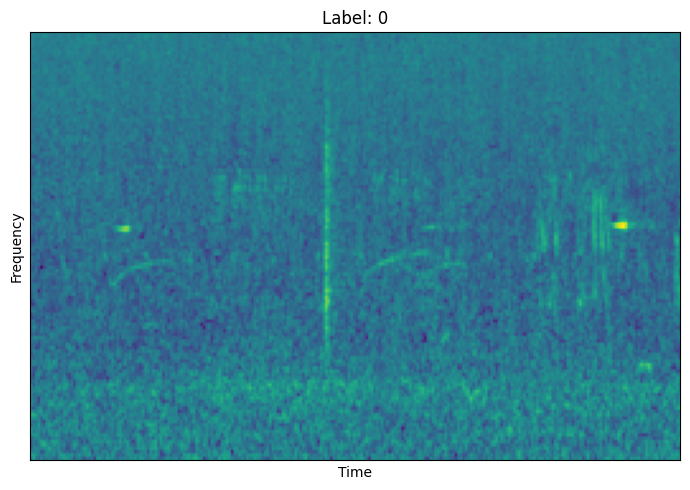

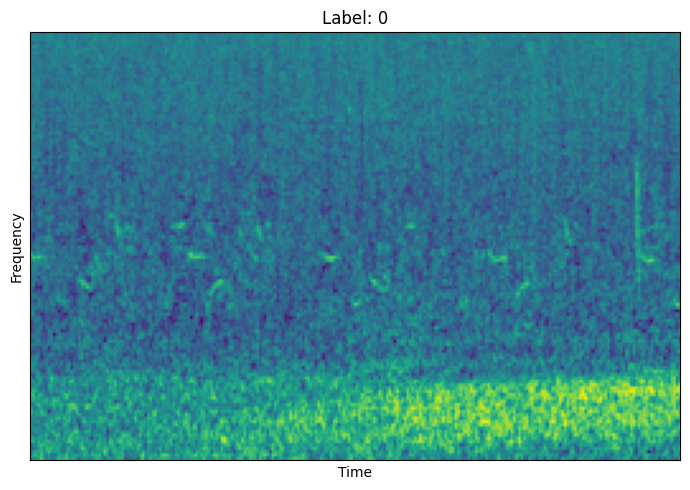

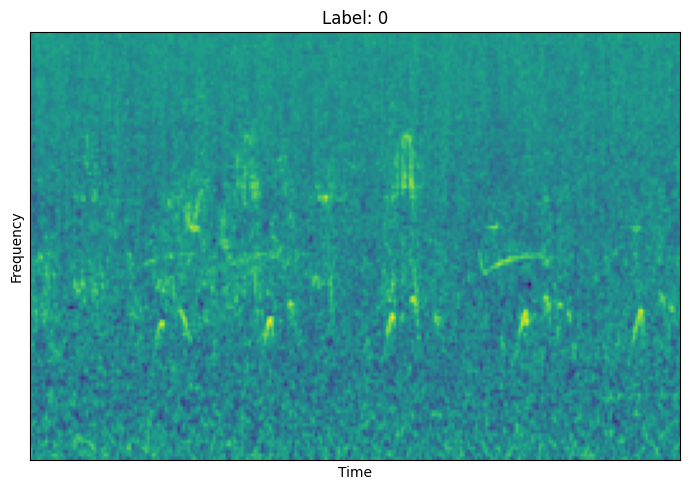

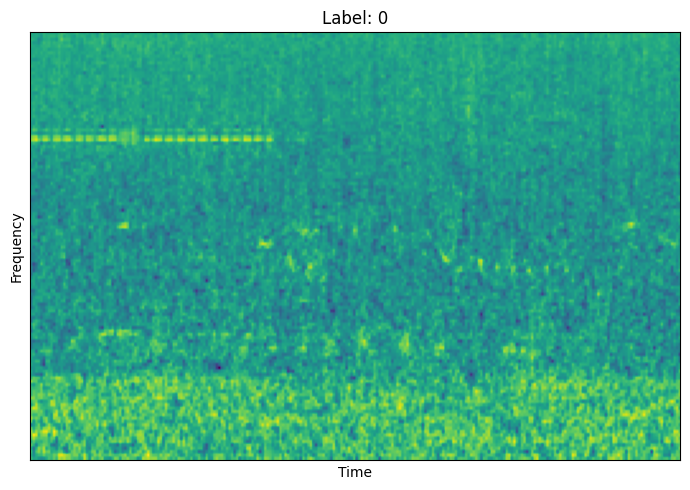

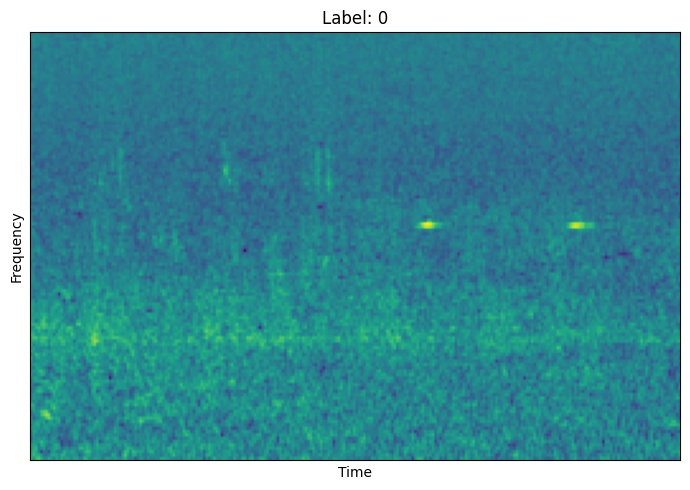

In [64]:
# Call the function with the loaded spectrogram_list and corresponding_labels
plot_random_spectrograms(spectrogram_list, [0 for _ in range(len(spectrogram_list))])

### Convert the data to PyTorch tensors

In [65]:
# Convert the lists of numpy arrays to single numpy arrays
spectrogram_test_np = np.array(spectrogram_list)

# Convert the numpy arrays to PyTorch tensors and add the channel dimension
X_test = torch.tensor(spectrogram_test_np).unsqueeze(1)

In [66]:
# Create TensorDataset instances
test_dataset = TensorDataset(X_test)

In [67]:
# Create a DataLoader for the test dataset
test_batch_size = len(spectrogram_list)
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [68]:
print(f"Number of test samples : {len(test_dataset)}")
print(f"Number of batches in test DataLoader: {len(test_data_loader)}")

Number of test samples : 120
Number of batches in test DataLoader: 1


# __Models__

## __EfficientNet_b7__

In [69]:
# For EfficientNet (saving)

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

def replace_memory_efficient_swish(module: nn.Module) -> nn.Module:
    for name, child in module.named_children():
        if isinstance(child, MemoryEfficientSwish):
            setattr(module, name, Swish())
        else:
            replace_memory_efficient_swish(child)
    return module

In [70]:
class EfficientNet_b7(nn.Module):
    def __init__(self, num_classes = 264):
        super(EfficientNet_b7, self).__init__()
        
        # Load the EfficientNet-B5 model with pretrained weights from ImageNet
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7', num_classes = num_classes)
        

    def forward(self, x):
        x = self.efficientnet(x)
        # x = F.softmax(x, dim=1)
        
        return x

In [71]:
my_EfficientNet = EfficientNet_b7(num_classes).to(device)

# Replace the MemoryEfficientSwish with Swish
my_EfficientNet = replace_memory_efficient_swish(my_EfficientNet)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to C:\Users\19722/.cache\torch\hub\checkpoints\efficientnet-b7-dcc49843.pth
100.0%


Loaded pretrained weights for efficientnet-b7


In [72]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in my_EfficientNet.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

64,463,064 model parameters


In [73]:
print(f"Is my model in GPU? : {next(my_EfficientNet.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 250.925MB


In [74]:
# Model functionality test
# Load a sample image
image = torch.randn([1, 3, 128, 224]).to(device)

# Run the model on the image
with torch.no_grad():
    my_EfficientNet.eval()
    output = my_EfficientNet(image)
    pred = output.argmax(dim = 1, keepdim = True)

print(image.size())
print(pred.item())
del image

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

torch.Size([1, 3, 128, 224])
135


### __Training__

In [75]:
def update_plots(loss_values_train, loss_values_val, acc_values_train, acc_values_val, print_messages):
    clear_output(wait = True)

    # Display print messages
    for message in print_messages:
        print(message)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 5))

    # Plot loss values
    ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = "Train Loss")
    ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = "Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.set_title("Loss values")
    ax1.grid(linestyle = "--", linewidth = 0.5)

    # Plot IoU values
    ax2.plot(range(1, len(acc_values_train) + 1), acc_values_train, label = "Train Acc")
    ax2.plot(range(1, len(acc_values_val) + 1), acc_values_val, label = "Validation Acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Acc")
    ax2.legend()
    ax2.set_title("Acc values")
    ax2.grid(linestyle = "--", linewidth = 0.5)

    plt.show()

In [76]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(my_EfficientNet.parameters(), lr = 5e-4, weight_decay = 5e-5)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)

num_epochs = 10

# Gradient accumulation
accumulation_steps = 5

In [77]:
epoch_list = []
loss_values_train = []
loss_values_val = []
acc_train = []
acc_val = []
history_learning_rate = []
print_messages = []
epoch_time = []
starting_epoch = 1

In [78]:
# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


	 ****** Training has begun. ******

Epoch: 001 | Learning Rate : 5.00000E-04 | Train Loss: 0.04324514 | Validation Loss: 0.02672492 | Train Acc: 0.5664 | Validation Acc: 0.7196 | Time: 00:11:28
Epoch: 002 | Learning Rate : 5.00000E-04 | Train Loss: 0.02184025 | Validation Loss: 0.02023305 | Train Acc: 0.7622 | Validation Acc: 0.7888 | Time: 00:23:32
Epoch: 003 | Learning Rate : 2.50000E-04 | Train Loss: 0.01146325 | Validation Loss: 0.01616103 | Train Acc: 0.8718 | Validation Acc: 0.8341 | Time: 00:35:17
Epoch: 004 | Learning Rate : 2.50000E-04 | Train Loss: 0.00731602 | Validation Loss: 0.01631204 | Train Acc: 0.9166 | Validation Acc: 0.8364 | Time: 00:46:46
Epoch: 005 | Learning Rate : 1.25000E-04 | Train Loss: 0.00391350 | Validation Loss: 0.01574278 | Train Acc: 0.9559 | Validation Acc: 0.8537 | Time: 00:58:22
Epoch: 006 | Learning Rate : 1.25000E-04 | Train Loss: 0.00254642 | Validation Loss: 0.01675199 | Train Acc: 0.9711 | Validation Acc: 0.8540 | Time: 01:10:24
Epoch: 007 | L

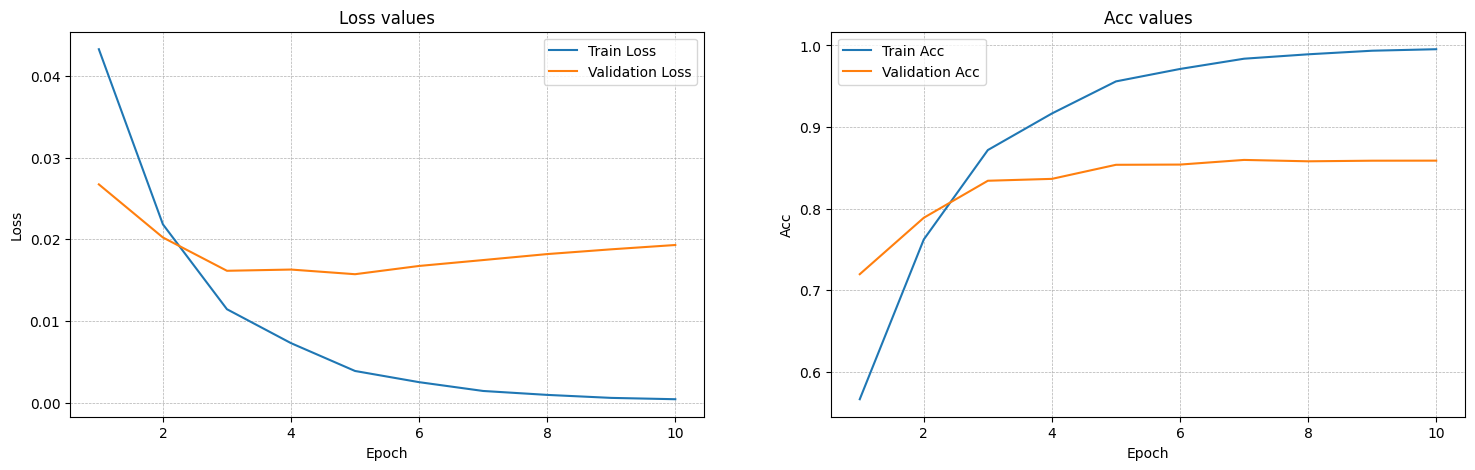

In [79]:
# Training process
start = timer()

message = '\n\t ****** Training has begun. ******\n'
print_messages.append(message)

# message = f"Initial learning rate : {optimizer.param_groups[0]['lr']}"
# print_messages.append(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

for epoch in range(starting_epoch, num_epochs + 1):
    epoch_list.append(epoch)
    ########################## TRAINING ###############################
    # Set the network to training mode
    my_EfficientNet.train()
    history_learning_rate.append(optimizer.param_groups[0]['lr'])


    train_correct, train_loss, image_len = 0, 0, 0


    # Iterate over the batches of training data
    for batch_idx, (inputs, labels) in enumerate(train_loader):
    # for batch in train_loader:
    #     inputs, labels = batch
      
        inputs, labels = inputs.to(device), labels.to(device)

        if torch.isinf(inputs).any():
            print('There are inf values in x')
            
        if torch.isnan(inputs).any():
            print('There are nan values in x')

        image_len += inputs.size()[0]

        # Resizing images for three channels
        inputs = inputs.repeat(1, 3, 1, 1)

        # Pass the images through the model (Forward pass)
        outputs = my_EfficientNet(inputs)
        pred = outputs.argmax(dim = 1, keepdim = True)

        # Compute the loss based on the targets
        # print(true_masks.size())
        loss_train = criterion(outputs, labels)

        # Accumulate loss
        train_loss += loss_train.item()

        # Accumulate correct
        train_correct += pred.eq(labels.view_as(pred)).sum().item()

        # Backward pass and optimization
        loss_train.backward()

        # Gradient accumulation
        if (batch_idx + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(my_EfficientNet.parameters(), max_norm = 10.0) # Gradient Clipping
            optimizer.step()

            # Zero the parameter gradients
            optimizer.zero_grad()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) # Gradient Clipping
        # optimizer.step()

        # Zero the parameter gradients
        # optimizer.zero_grad()

    # Add loss and Acc to history
    loss_values_train.append(train_loss / image_len)
    acc_train.append(train_correct / image_len)


    ########################## VALIDATION ###############################
    # Set the network to testing validation
    my_EfficientNet.eval()
    
    val_correct, val_loss, image_len = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
        
            inputs, labels = inputs.to(device), labels.to(device)

            image_len += inputs.size()[0]

            # Resizing images for three channels
            inputs = inputs.repeat(1, 3, 1, 1)

            # Pass the images through the model (Forward pass)
            outputs = my_EfficientNet(inputs)
            pred = outputs.argmax(dim = 1, keepdim = True)

            # Compute the loss based on the targets
            loss_val = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss_val.item()

            # Accumulate correct
            val_correct += pred.eq(labels.view_as(pred)).sum().item()

    # Add loss and Acc to history
    loss_values_val.append(val_loss / image_len)
    acc_val.append(val_correct / image_len)


    # Scheduler of learning rate
    scheduler.step()

    # Print training statistics
    time_stamp = datetime.now().timestamp()
    current_time = datetime.fromtimestamp(time_stamp).strftime("%H:%M:%S")
    epoch_time.append(timedelta(seconds = int(timer()- start)).__str__().zfill(8))
    message = f"Epoch: {epoch:03} | Learning Rate : {history_learning_rate[-1]:.5E} | Train Loss: {loss_values_train[-1]:.8f} | Validation Loss: {loss_values_val[-1]:.8f} | Train Acc: {acc_train[-1]:.4f} | Validation Acc: {acc_val[-1]:.4f} | Time: {epoch_time[-1]}"
    print_messages.append(message)

    # Update the plots
    update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

    # Save the model's state_dict (weights):
    if (epoch % 2 == 0) or (acc_val[-1] >= 0.75):
        # Save the model:
        # Create a dummy input tensor with the correct dimensions for the model
        dummy_input = torch.randn(1, 3, 128, 224).to(device)

        # Use torch.jit.trace to convert the model to TorchScript using the dummy input
        model_scripted = torch.jit.trace(my_EfficientNet, dummy_input) # Export to TorchScript using script
        model_name = my_EfficientNet.__class__.__name__
        model_scripted.save(model_name + "_" + str(epoch) + ".pt")


        # file_name = f'model_{epoch}.pth'
        # torch.save(my_EfficientNet.state_dict(), file_name)

        file_name = f'{model_name}_weights_{epoch}.pth'
        torch.save(my_EfficientNet.state_dict(), file_name)


end = timer()
message = '\n\n\t ****** Training has finished. ******\n'
print_messages.append(message)
print(message)
message = f'\tTraining time: {timedelta(seconds = int(end-start)).__str__().zfill(8)} [hh:mm:ss]'
print_messages.append(message)
print(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# current_epoch = epoch
# starting_epoch = current_epoch + 1
# print(f"Current epoch : {current_epoch}")
# print(f"Starting epoch : {starting_epoch}")


In [59]:
# creating the DataFrame
EfficientNet_b7_outcomes = pd.DataFrame(
    {'Epoch': epoch_list,
     'Learning_Rate' : history_learning_rate,
     'Train_Loss': loss_values_train,
     'Validation_Loss': loss_values_val,
     'Train_Accuracy' : acc_train,
     'Validation_Accuracy' : acc_val,
     'Time': epoch_time
    })

# saving the DataFrame as a CSV file
EfficientNet_b7_outcomes.to_csv('EfficientNet_b7_outcomes.csv', index = False)

#### __Plot of the Loss and the Accuracy History__

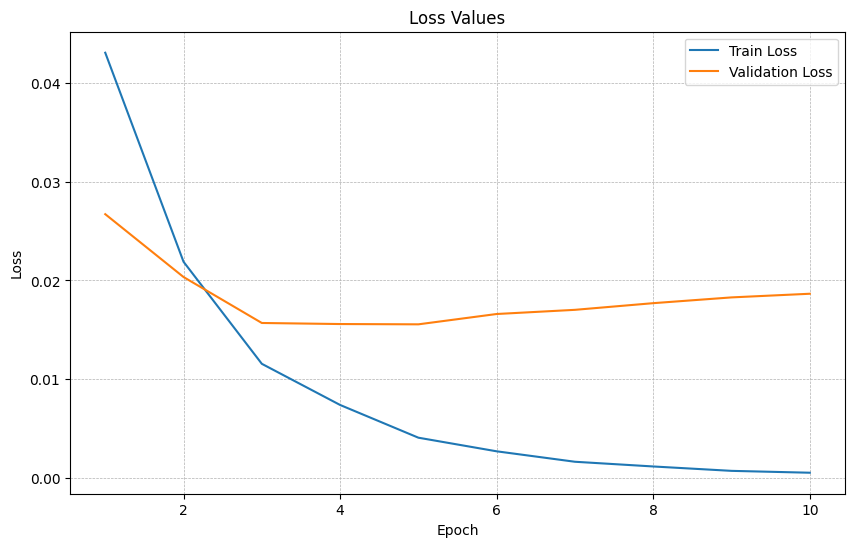

In [62]:
# Create the first plot for loss values
fig1, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Values')
ax1.grid(linestyle='--', linewidth = 0.5)

plt.show()

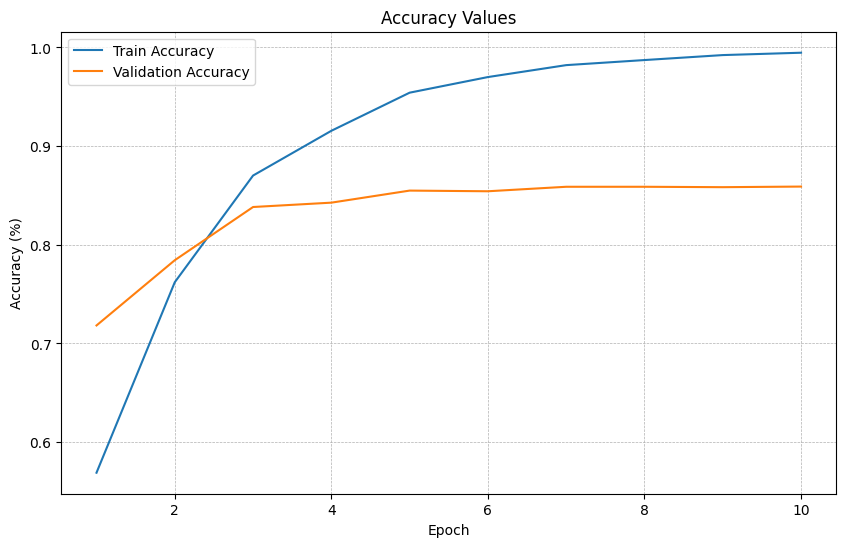

In [61]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(acc_train) + 1), acc_train, label = 'Train Accuracy')
ax2.plot(range(1, len(acc_val) + 1), acc_val, label = 'Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy Values')
ax2.grid(linestyle='--', linewidth=0.5)

plt.show()

#### __History of the Learning Rate__

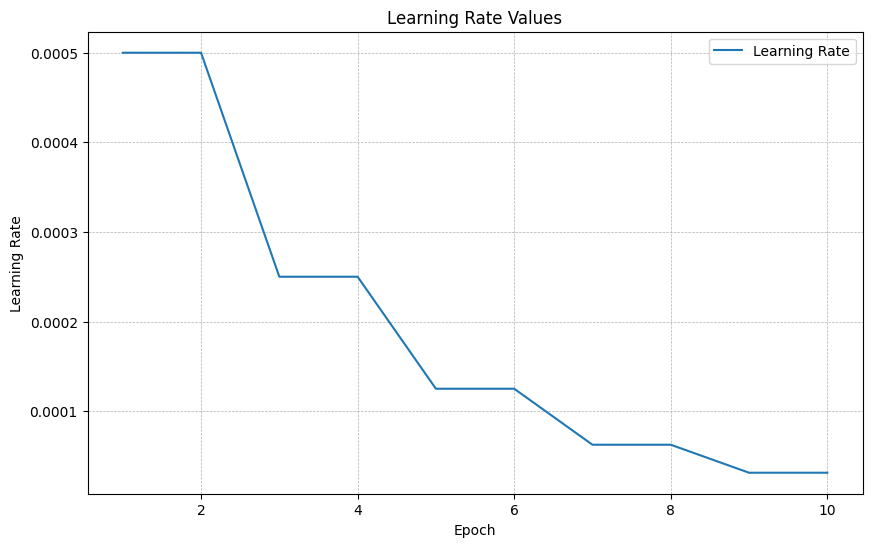

In [63]:
# Plot learning rate values
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(history_learning_rate) + 1), history_learning_rate, label = 'Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Values')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

#### __Evaluation Techniques__

In [6]:
# my_EfficientNet = torch.load('EfficientNet_b7.pt').to(device)

In [7]:
predictions = []
actuals = []

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


for inputs, labels in val_loader:

    inputs = inputs.to(device)

    # Resizing images for three channels
    inputs = inputs.repeat(1, 3, 1, 1)

    # Make predictions with your model
    outputs = my_EfficientNet(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Store the predictions and actual labels
    predicted = predicted.cpu()
    predictions.append(predicted.numpy().tolist())
    actuals.append(labels.numpy().tolist())

    # Release GPU memory cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [8]:
# Flatten the lists of predictions and actual labels
predictions = [item for sublist in predictions for item in sublist]
actuals = [item for sublist in actuals for item in sublist]

### __Accuracy__

In [9]:
# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)
print(f"Accuracy : {accuracy * 100:.2f} %")

Accuracy : 85.88 %


### __F1 Score__

In [10]:
# Calculate F1 score
f1 = f1_score(actuals, predictions, average = 'macro')
print(f"F1 Score : {f1 * 100:.2f} %")

F1 Score : 79.26 %


### __Average Precision (AP)__

In [11]:
# Calculate average precision (AP)

# Binarize the output
n_classes = np.unique(actuals).size
y_true_bin = label_binarize(actuals, classes=np.arange(num_classes))
y_score_bin = label_binarize(predictions, classes=np.arange(num_classes))

# Compute AP for each class and average them
average_precision = 0
for i in range(num_classes):
    average_precision += average_precision_score(y_true_bin[:, i], y_score_bin[:, i])
average_precision /= num_classes

print(f"Average Precision (AP): {average_precision:.2f}")

Average Precision (AP): 0.66


### __Macro-Averaging (MA)__

In [12]:
# Calculate macro-averaging (MA)
precision, recall, fscore, _ = precision_recall_fscore_support(actuals, predictions, average='macro')
macro_average = np.mean([precision, recall, fscore])

print(f"Macro-Averaging (MA) : {macro_average:.2f}")

Macro-Averaging (MA) : 0.80


### __Save Data__

In [25]:
# Create an empty DataFrame with columns
columns = ['model_name', 'accuracy', 'f1_score', 'average_precision', 'macro-averaging']
evaluation_models = pd.DataFrame(columns = columns)

In [26]:
# Add a row of data
evaluation_models.loc[len(evaluation_models)] = ["EfficientNet_b7", accuracy, f1, average_precision, macro_average]

In [27]:
# Save the DataFrame to a CSV file
evaluation_models.to_csv('evaluation_models.csv', index=False)

## __ResNet101__

In [6]:
class ResNet101Model(nn.Module):
    def __init__(self, num_classes = 264):
        super(ResNet101Model, self).__init__()

        # Load the ResNet101 model with pretrained weights from ImageNet
        self.resnet = resnet101(pretrained = True)

        # Adjust the output layer to the number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        # x = F.softmax(x, dim=1)

        return x

In [7]:
my_ResNet101 = ResNet101Model()
my_ResNet101 = my_ResNet101.to(device)

In [8]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in my_ResNet101.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

43,041,096 model parameters


In [9]:
print(f"Is my model in GPU? : {next(my_ResNet101.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 165.836MB


In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(my_ResNet101.parameters(), lr = 5e-4, weight_decay = 5e-5)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)

num_epochs = 10

# Gradient accumulation
accumulation_steps = 5

In [17]:
epoch_list = []
loss_values_train = []
loss_values_val = []
acc_train = []
acc_val = []
history_learning_rate = []
print_messages = []
epoch_time = []
starting_epoch = 1

In [18]:
# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


	 ****** Training has begun. ******

Epoch: 001 | Learning Rate : 5.00000E-04 | Train Loss: 0.04298886 | Validation Loss: 0.03202285 | Train Acc: 0.5610 | Validation Acc: 0.6592 | Time: 00:05:49
Epoch: 002 | Learning Rate : 5.00000E-04 | Train Loss: 0.02665042 | Validation Loss: 0.02480561 | Train Acc: 0.7105 | Validation Acc: 0.7333 | Time: 00:11:44
Epoch: 003 | Learning Rate : 2.50000E-04 | Train Loss: 0.01612574 | Validation Loss: 0.01908263 | Train Acc: 0.8221 | Validation Acc: 0.7986 | Time: 00:17:44
Epoch: 004 | Learning Rate : 2.50000E-04 | Train Loss: 0.01135903 | Validation Loss: 0.01844222 | Train Acc: 0.8710 | Validation Acc: 0.8049 | Time: 00:23:42
Epoch: 005 | Learning Rate : 1.25000E-04 | Train Loss: 0.00600926 | Validation Loss: 0.01726056 | Train Acc: 0.9332 | Validation Acc: 0.8313 | Time: 00:29:40
Epoch: 006 | Learning Rate : 1.25000E-04 | Train Loss: 0.00364866 | Validation Loss: 0.01889516 | Train Acc: 0.9607 | Validation Acc: 0.8265 | Time: 00:35:31
Epoch: 007 | L

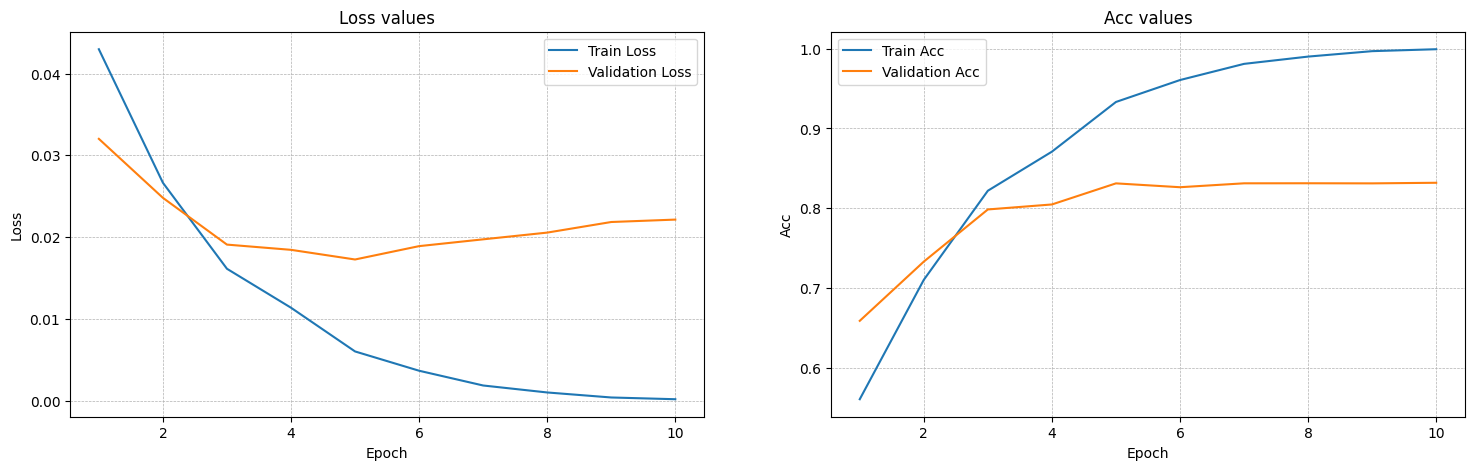

In [19]:
# Training process
start = timer()

message = '\n\t ****** Training has begun. ******\n'
print_messages.append(message)


# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

for epoch in range(starting_epoch, num_epochs + 1):
    epoch_list.append(epoch)
    ########################## TRAINING ###############################
    # Set the network to training mode
    my_ResNet101.train()
    history_learning_rate.append(optimizer.param_groups[0]['lr'])


    train_correct, train_loss, image_len = 0, 0, 0


    # Iterate over the batches of training data
    for batch_idx, (inputs, labels) in enumerate(train_loader):
    # for batch in train_loader:
    #     inputs, labels = batch
      
        inputs, labels = inputs.to(device), labels.to(device)

        if torch.isinf(inputs).any():
            print('There are inf values in x')
            
        if torch.isnan(inputs).any():
            print('There are nan values in x')

        image_len += inputs.size()[0]

        # Resizing images for three channels
        inputs = inputs.repeat(1, 3, 1, 1)

        # Pass the images through the model (Forward pass)
        outputs = my_ResNet101(inputs)
        pred = outputs.argmax(dim = 1, keepdim = True)

        # Compute the loss based on the targets
        # print(true_masks.size())
        loss_train = criterion(outputs, labels)

        # Accumulate loss
        train_loss += loss_train.item()

        # Accumulate correct
        train_correct += pred.eq(labels.view_as(pred)).sum().item()

        # Backward pass and optimization
        loss_train.backward()

        # Gradient accumulation
        if (batch_idx + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(my_ResNet101.parameters(), max_norm = 10.0) # Gradient Clipping
            optimizer.step()

            # Zero the parameter gradients
            optimizer.zero_grad()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) # Gradient Clipping
        # optimizer.step()

        # Zero the parameter gradients
        # optimizer.zero_grad()

    # Add loss and Acc to history
    loss_values_train.append(train_loss / image_len)
    acc_train.append(train_correct / image_len)


    ########################## VALIDATION ###############################
    # Set the network to testing validation
    my_ResNet101.eval()
    
    val_correct, val_loss, image_len = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
        
            inputs, labels = inputs.to(device), labels.to(device)

            image_len += inputs.size()[0]

            # Resizing images for three channels
            inputs = inputs.repeat(1, 3, 1, 1)

            # Pass the images through the model (Forward pass)
            outputs = my_ResNet101(inputs)
            pred = outputs.argmax(dim = 1, keepdim = True)

            # Compute the loss based on the targets
            loss_val = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss_val.item()

            # Accumulate correct
            val_correct += pred.eq(labels.view_as(pred)).sum().item()

    # Add loss and Acc to history
    loss_values_val.append(val_loss / image_len)
    acc_val.append(val_correct / image_len)


    # Scheduler of learning rate
    scheduler.step()

    # Print training statistics
    time_stamp = datetime.now().timestamp()
    current_time = datetime.fromtimestamp(time_stamp).strftime("%H:%M:%S")
    epoch_time.append(timedelta(seconds = int(timer()- start)).__str__().zfill(8))
    message = f"Epoch: {epoch:03} | Learning Rate : {history_learning_rate[-1]:.5E} | Train Loss: {loss_values_train[-1]:.8f} | Validation Loss: {loss_values_val[-1]:.8f} | Train Acc: {acc_train[-1]:.4f} | Validation Acc: {acc_val[-1]:.4f} | Time: {epoch_time[-1]}"
    print_messages.append(message)

    # Update the plots
    update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

    # Save the model's state_dict (weights):
    if (epoch % 2 == 0) or (acc_val[-1] >= 0.75):
        # Save the model:
        # Create a dummy input tensor with the correct dimensions for the model
        dummy_input = torch.randn(1, 3, 128, 224).to(device)

        # Use torch.jit.trace to convert the model to TorchScript using the dummy input
        model_scripted = torch.jit.trace(my_ResNet101, dummy_input) # Export to TorchScript using script
        model_name = my_ResNet101.__class__.__name__
        model_scripted.save(model_name + "_" + str(epoch) + ".pt")


        file_name = f'{model_name}_weights_{epoch}.pth'
        torch.save(my_ResNet101.state_dict(), file_name)


end = timer()
message = '\n\n\t ****** Training has finished. ******\n'
print_messages.append(message)
print(message)
message = f'\tTraining time: {timedelta(seconds = int(end-start)).__str__().zfill(8)} [hh:mm:ss]'
print_messages.append(message)
print(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [20]:
# creating the DataFrame
ResNet101_outcomes = pd.DataFrame(
    {'Epoch': epoch_list,
     'Learning_Rate' : history_learning_rate,
     'Train_Loss': loss_values_train,
     'Validation_Loss': loss_values_val,
     'Train_Accuracy' : acc_train,
     'Validation_Accuracy' : acc_val,
     'Time': epoch_time
    })

# saving the DataFrame as a CSV file
ResNet101_outcomes.to_csv('ResNet101_outcomes.csv', index = False)

#### __Plot of the Loss and the Accuracy History__

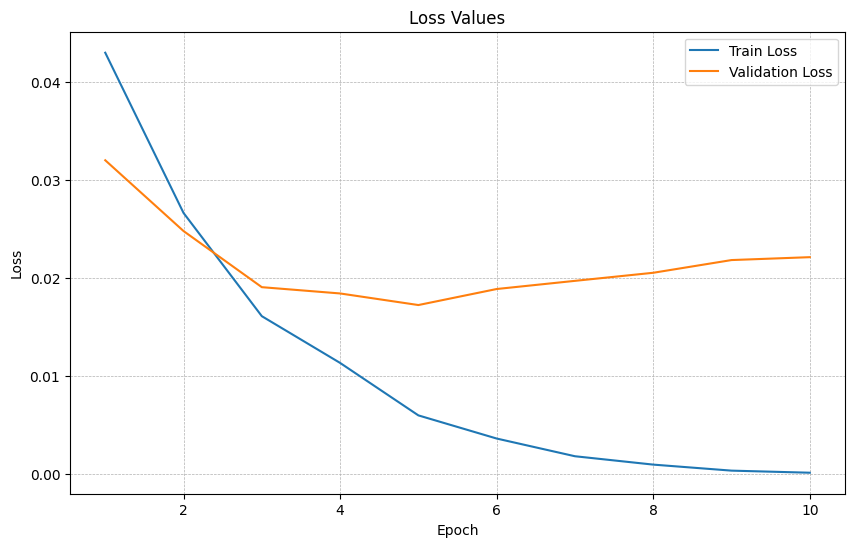

In [21]:
# Create the first plot for loss values
fig1, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Values')
ax1.grid(linestyle='--', linewidth = 0.5)

plt.show()

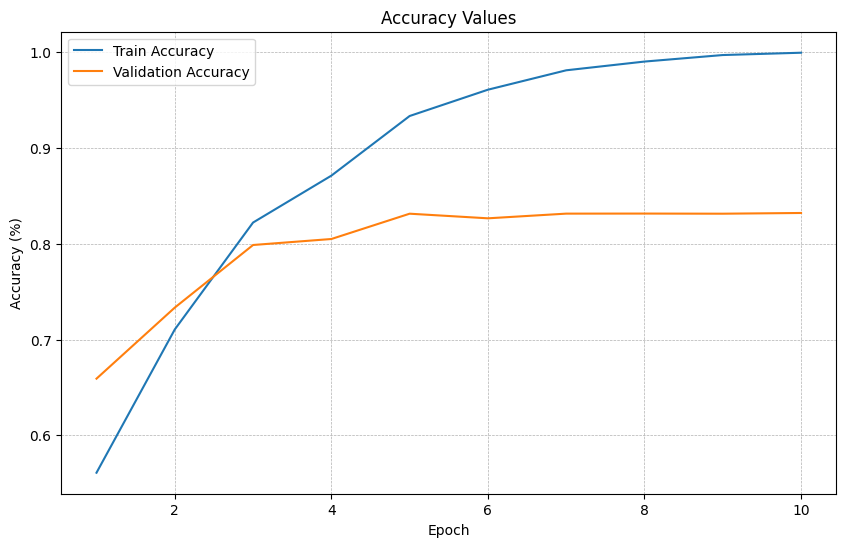

In [22]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(acc_train) + 1), acc_train, label = 'Train Accuracy')
ax2.plot(range(1, len(acc_val) + 1), acc_val, label = 'Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy Values')
ax2.grid(linestyle='--', linewidth=0.5)

plt.show()

#### __Evaluation Techniques__

In [7]:
# my_ResNet101 = torch.load('ResNet101.pt').to(device)

In [8]:
predictions = []
actuals = []

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


for inputs, labels in val_loader:

    inputs = inputs.to(device)

    # Resizing images for three channels
    inputs = inputs.repeat(1, 3, 1, 1)

    # Make predictions with your model
    outputs = my_ResNet101(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Store the predictions and actual labels
    predicted = predicted.cpu()
    predictions.append(predicted.numpy().tolist())
    actuals.append(labels.numpy().tolist())

    # Release GPU memory cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [9]:
# Flatten the lists of predictions and actual labels
predictions = [item for sublist in predictions for item in sublist]
actuals = [item for sublist in actuals for item in sublist]

### __Accuracy__

In [10]:
# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)
print(f"Accuracy : {accuracy * 100:.2f} %")

Accuracy : 83.20 %


### __F1 Score__

In [11]:
# Calculate F1 score
f1 = f1_score(actuals, predictions, average = 'macro')
print(f"F1 Score : {f1 * 100:.2f} %")

F1 Score : 74.46 %


### __Average Precision (AP)__

In [12]:
# Calculate average precision (AP)

# Binarize the output
n_classes = np.unique(actuals).size
y_true_bin = label_binarize(actuals, classes=np.arange(num_classes))
y_score_bin = label_binarize(predictions, classes=np.arange(num_classes))

# Compute AP for each class and average them
average_precision = 0
for i in range(num_classes):
    average_precision += average_precision_score(y_true_bin[:, i], y_score_bin[:, i])
average_precision /= num_classes

print(f"Average Precision (AP): {average_precision:.2f}")

Average Precision (AP): 0.59


### __Macro-Averaging (MA)__

In [13]:
# Calculate macro-averaging (MA)
precision, recall, fscore, _ = precision_recall_fscore_support(actuals, predictions, average='macro')
macro_average = np.mean([precision, recall, fscore])

print(f"Macro-Averaging (MA) : {macro_average:.2f}")

Macro-Averaging (MA) : 0.75


### __Save Data__

In [15]:
# Load the DataFrame from the CSV file
evaluation_models = pd.read_csv('evaluation_models.csv')

In [16]:
# Add a row of data
evaluation_models.loc[len(evaluation_models)] = ["ResNet101", accuracy, f1, average_precision, macro_average]

In [17]:
# Save the DataFrame to a CSV file
evaluation_models.to_csv('evaluation_models.csv', index=False)

## __GoogLeNet (Inception)__

In [12]:
class GoogLeNetModel(nn.Module):
    def __init__(self, num_classes = 264):
        super(GoogLeNetModel, self).__init__()

        # Load the GoogLeNet model with pretrained weights from ImageNet
        self.googlenet = googlenet(pretrained = True)

        # Change the first layer to accept single-channel input
        # self.googlenet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Adjust the output layer to the number of classes
        self.googlenet.fc = nn.Linear(self.googlenet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.googlenet(x)
        # x = F.softmax(x, dim=1)

        return x

In [13]:
my_GoogLeNet = GoogLeNetModel()
my_GoogLeNet = my_GoogLeNet.to(device)

In [14]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in my_GoogLeNet.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

5,870,504 model parameters


In [15]:
print(f"Is my model in GPU? : {next(my_GoogLeNet.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 22.523MB


In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(my_GoogLeNet.parameters(), lr = 5e-4, weight_decay = 5e-5)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5)

num_epochs = 10

# Gradient accumulation
accumulation_steps = 5

In [23]:
epoch_list = []
loss_values_train = []
loss_values_val = []
acc_train = []
acc_val = []
history_learning_rate = []
print_messages = []
epoch_time = []
starting_epoch = 1

In [24]:
# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


	 ****** Training has begun. ******

Epoch: 001 | Learning Rate : 5.00000E-04 | Train Loss: 0.04585342 | Validation Loss: 0.03140723 | Train Acc: 0.5433 | Validation Acc: 0.6682 | Time: 00:01:47
Epoch: 002 | Learning Rate : 5.00000E-04 | Train Loss: 0.02757764 | Validation Loss: 0.02495371 | Train Acc: 0.7048 | Validation Acc: 0.7367 | Time: 00:03:31
Epoch: 003 | Learning Rate : 2.50000E-04 | Train Loss: 0.01841482 | Validation Loss: 0.02056335 | Train Acc: 0.7991 | Validation Acc: 0.7853 | Time: 00:05:16
Epoch: 004 | Learning Rate : 2.50000E-04 | Train Loss: 0.01409602 | Validation Loss: 0.01933052 | Train Acc: 0.8450 | Validation Acc: 0.7977 | Time: 00:07:00
Epoch: 005 | Learning Rate : 1.25000E-04 | Train Loss: 0.00947247 | Validation Loss: 0.01812013 | Train Acc: 0.8973 | Validation Acc: 0.8144 | Time: 00:08:44
Epoch: 006 | Learning Rate : 1.25000E-04 | Train Loss: 0.00723091 | Validation Loss: 0.01852130 | Train Acc: 0.9232 | Validation Acc: 0.8138 | Time: 00:10:30
Epoch: 007 | L

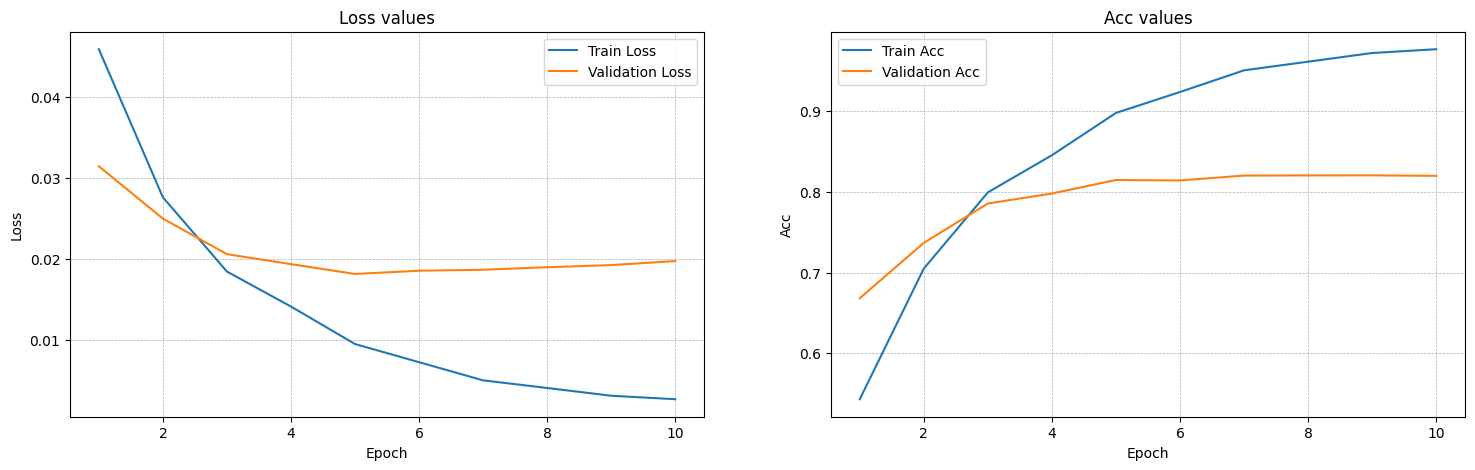

In [25]:
# Training process
start = timer()

message = '\n\t ****** Training has begun. ******\n'
print_messages.append(message)


# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

for epoch in range(starting_epoch, num_epochs + 1):
    epoch_list.append(epoch)
    ########################## TRAINING ###############################
    # Set the network to training mode
    my_GoogLeNet.train()
    history_learning_rate.append(optimizer.param_groups[0]['lr'])


    train_correct, train_loss, image_len = 0, 0, 0


    # Iterate over the batches of training data
    for batch_idx, (inputs, labels) in enumerate(train_loader):
    # for batch in train_loader:
    #     inputs, labels = batch
      
        inputs, labels = inputs.to(device), labels.to(device)

        if torch.isinf(inputs).any():
            print('There are inf values in x')
            
        if torch.isnan(inputs).any():
            print('There are nan values in x')

        image_len += inputs.size()[0]

        # Resizing images for three channels
        inputs = inputs.repeat(1, 3, 1, 1)

        # Pass the images through the model (Forward pass)
        outputs = my_GoogLeNet(inputs)
        pred = outputs.argmax(dim = 1, keepdim = True)

        # Compute the loss based on the targets
        # print(true_masks.size())
        loss_train = criterion(outputs, labels)

        # Accumulate loss
        train_loss += loss_train.item()

        # Accumulate correct
        train_correct += pred.eq(labels.view_as(pred)).sum().item()

        # Backward pass and optimization
        loss_train.backward()

        # Gradient accumulation
        if (batch_idx + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(my_GoogLeNet.parameters(), max_norm = 10.0) # Gradient Clipping
            optimizer.step()

            # Zero the parameter gradients
            optimizer.zero_grad()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) # Gradient Clipping
        # optimizer.step()

        # Zero the parameter gradients
        # optimizer.zero_grad()

    # Add loss and Acc to history
    loss_values_train.append(train_loss / image_len)
    acc_train.append(train_correct / image_len)


    ########################## VALIDATION ###############################
    # Set the network to testing validation
    my_GoogLeNet.eval()
    
    val_correct, val_loss, image_len = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
        
            inputs, labels = inputs.to(device), labels.to(device)

            image_len += inputs.size()[0]

            # Resizing images for three channels
            inputs = inputs.repeat(1, 3, 1, 1)

            # Pass the images through the model (Forward pass)
            outputs = my_GoogLeNet(inputs)
            pred = outputs.argmax(dim = 1, keepdim = True)

            # Compute the loss based on the targets
            loss_val = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss_val.item()

            # Accumulate correct
            val_correct += pred.eq(labels.view_as(pred)).sum().item()

    # Add loss and Acc to history
    loss_values_val.append(val_loss / image_len)
    acc_val.append(val_correct / image_len)


    # Scheduler of learning rate
    scheduler.step()

    # Print training statistics
    time_stamp = datetime.now().timestamp()
    current_time = datetime.fromtimestamp(time_stamp).strftime("%H:%M:%S")
    epoch_time.append(timedelta(seconds = int(timer()- start)).__str__().zfill(8))
    message = f"Epoch: {epoch:03} | Learning Rate : {history_learning_rate[-1]:.5E} | Train Loss: {loss_values_train[-1]:.8f} | Validation Loss: {loss_values_val[-1]:.8f} | Train Acc: {acc_train[-1]:.4f} | Validation Acc: {acc_val[-1]:.4f} | Time: {epoch_time[-1]}"
    print_messages.append(message)

    # Update the plots
    update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

    # Save the model's state_dict (weights):
    if (epoch % 2 == 0) or (acc_val[-1] >= 0.75):
        # Save the model:
        # Create a dummy input tensor with the correct dimensions for the model
        dummy_input = torch.randn(1, 3, 128, 224).to(device)

        # Use torch.jit.trace to convert the model to TorchScript using the dummy input
        model_scripted = torch.jit.trace(my_GoogLeNet, dummy_input) # Export to TorchScript using script
        model_name = my_GoogLeNet.__class__.__name__
        model_scripted.save(model_name + "_" + str(epoch) + ".pt")


        file_name = f'{model_name}_weights_{epoch}.pth'
        torch.save(my_GoogLeNet.state_dict(), file_name)


end = timer()
message = '\n\n\t ****** Training has finished. ******\n'
print_messages.append(message)
print(message)
message = f'\tTraining time: {timedelta(seconds = int(end-start)).__str__().zfill(8)} [hh:mm:ss]'
print_messages.append(message)
print(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, acc_train, acc_val, print_messages)

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [26]:
# creating the DataFrame
GoogLeNet_outcomes = pd.DataFrame(
    {'Epoch': epoch_list,
     'Learning_Rate' : history_learning_rate,
     'Train_Loss': loss_values_train,
     'Validation_Loss': loss_values_val,
     'Train_Accuracy' : acc_train,
     'Validation_Accuracy' : acc_val,
     'Time': epoch_time
    })

# saving the DataFrame as a CSV file
GoogLeNet_outcomes.to_csv('GoogLeNet_outcomes.csv', index = False)

#### __Plot of the Loss and the Accuracy History__

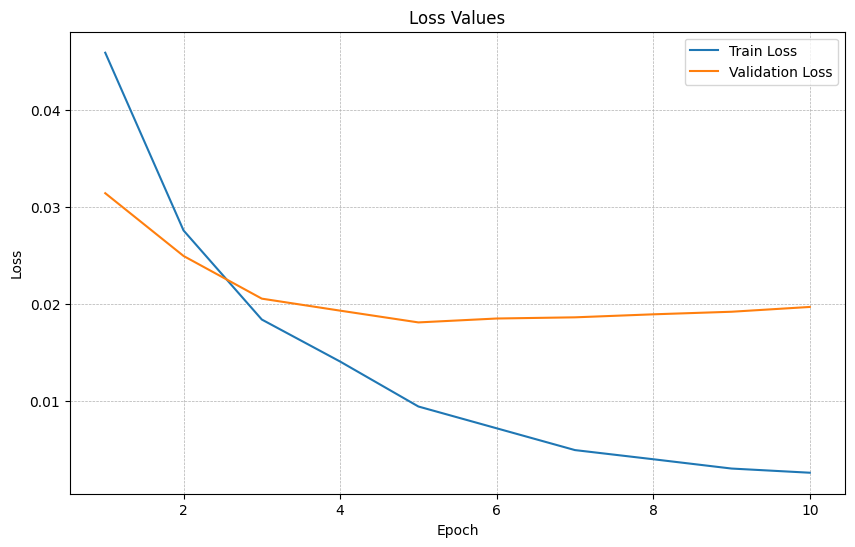

In [27]:
# Create the first plot for loss values
fig1, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Values')
ax1.grid(linestyle='--', linewidth = 0.5)

plt.show()

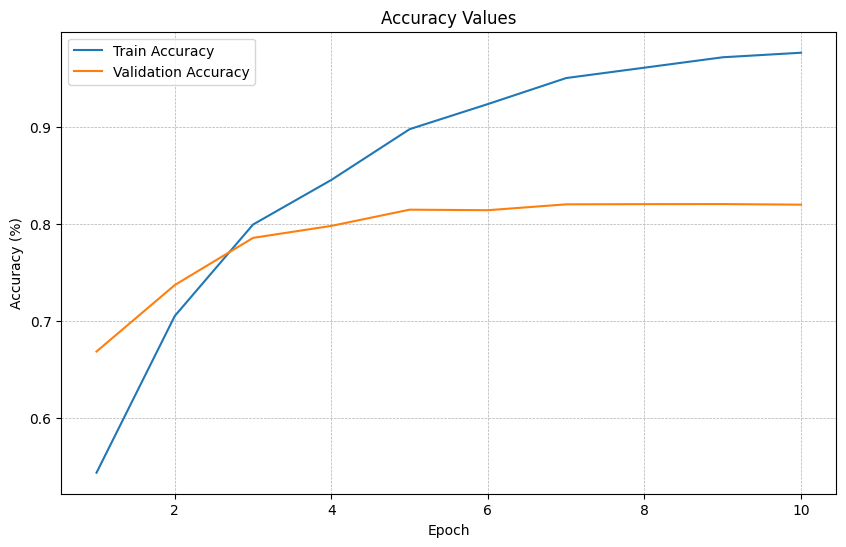

In [28]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(acc_train) + 1), acc_train, label = 'Train Accuracy')
ax2.plot(range(1, len(acc_val) + 1), acc_val, label = 'Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy Values')
ax2.grid(linestyle='--', linewidth=0.5)

plt.show()

#### __Evaluation Techniques__

In [18]:
my_GoogLeNet = torch.load('GoogLeNet.pt').to(device)

In [19]:
predictions = []
actuals = []

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()


for inputs, labels in val_loader:

    inputs = inputs.to(device)

    # Resizing images for three channels
    inputs = inputs.repeat(1, 3, 1, 1)

    # Make predictions with your model
    outputs = my_GoogLeNet(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Store the predictions and actual labels
    predicted = predicted.cpu()
    predictions.append(predicted.numpy().tolist())
    actuals.append(labels.numpy().tolist())

    # Release GPU memory cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [20]:
# Flatten the lists of predictions and actual labels
predictions = [item for sublist in predictions for item in sublist]
actuals = [item for sublist in actuals for item in sublist]

### __Accuracy__

In [21]:
# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)
print(f"Accuracy : {accuracy * 100:.2f} %")

Accuracy : 82.01 %


### __F1 Score__


In [22]:
# Calculate F1 score
f1 = f1_score(actuals, predictions, average = 'macro')
print(f"F1 Score : {f1 * 100:.2f} %")

F1 Score : 72.09 %


### __Average Precision (AP)__

In [23]:
# Calculate average precision (AP)

# Binarize the output
n_classes = np.unique(actuals).size
y_true_bin = label_binarize(actuals, classes=np.arange(num_classes))
y_score_bin = label_binarize(predictions, classes=np.arange(num_classes))

# Compute AP for each class and average them
average_precision = 0
for i in range(num_classes):
    average_precision += average_precision_score(y_true_bin[:, i], y_score_bin[:, i])
average_precision /= num_classes

print(f"Average Precision (AP): {average_precision:.2f}")

Average Precision (AP): 0.56


### __Macro-Averaging (MA)__

In [24]:
# Calculate macro-averaging (MA)
precision, recall, fscore, _ = precision_recall_fscore_support(actuals, predictions, average='macro')
macro_average = np.mean([precision, recall, fscore])

print(f"Macro-Averaging (MA) : {macro_average:.2f}")

Macro-Averaging (MA) : 0.73


### __Save Data__

In [25]:
# Load the DataFrame from the CSV file
evaluation_models = pd.read_csv('evaluation_models.csv')

In [31]:
# Add a row of data
evaluation_models.loc[len(evaluation_models)] = ["GoogLeNet", accuracy, f1, average_precision, macro_average]

In [32]:
# Save the DataFrame to a CSV file
evaluation_models.to_csv('evaluation_models.csv', index=False)

# __Final Summary__

In [31]:
EfficientNet_b7_outcomes = pd.read_csv('EfficientNet_b7_outcomes.csv')
ResNet101_outcomes = pd.read_csv('ResNet101_outcomes.csv')
GoogLeNet_outcomes = pd.read_csv('GoogLeNet_outcomes.csv')

x = [i for i in range(1, len(EfficientNet_b7_outcomes) + 1)]

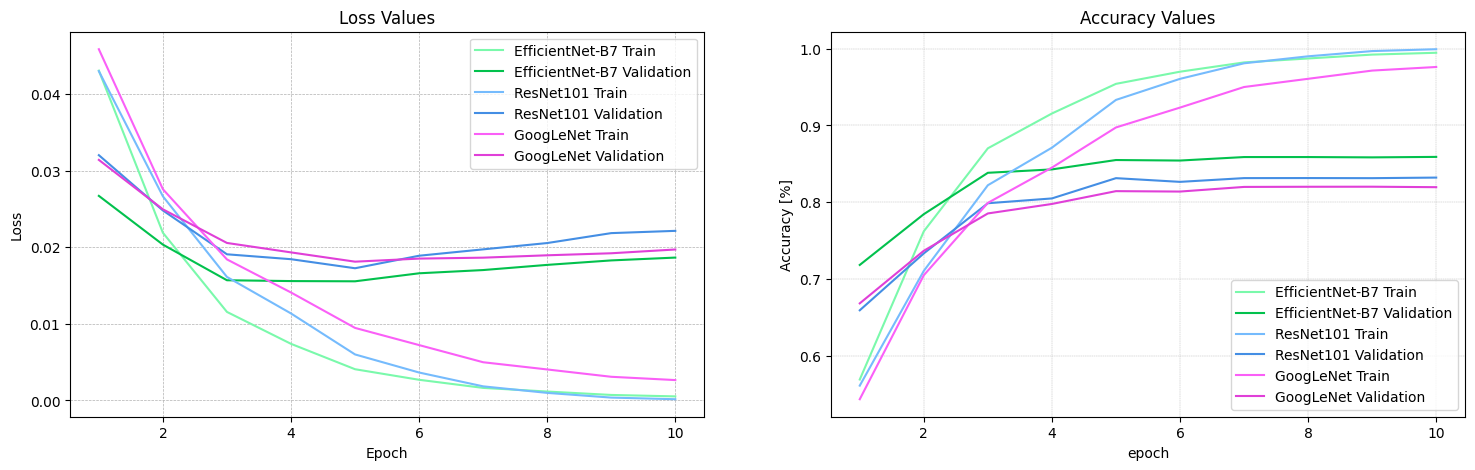

In [43]:
plt.figure(figsize = (18, 5)) 

plt.subplot(121)
plt.plot(x, EfficientNet_b7_outcomes.Train_Loss, c = 'xkcd:seafoam green')
plt.plot(x, EfficientNet_b7_outcomes.Validation_Loss, c = 'xkcd:shamrock green')

plt.plot(x, ResNet101_outcomes.Train_Loss, c = 'xkcd:sky blue')
plt.plot(x, ResNet101_outcomes.Validation_Loss, c = 'xkcd:dark sky blue')

plt.plot(x, GoogLeNet_outcomes.Train_Loss, c = 'xkcd:light magenta')
plt.plot(x, GoogLeNet_outcomes.Validation_Loss, c = 'xkcd:purple pink')

plt.legend(['EfficientNet-B7 Train','EfficientNet-B7 Validation','ResNet101 Train','ResNet101 Validation',
           'GoogLeNet Train','GoogLeNet Validation'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss Values")
plt.grid(linestyle = "--", linewidth = 0.5)

plt.subplot(122)

plt.plot(x, EfficientNet_b7_outcomes.Train_Accuracy, c = 'xkcd:seafoam green')
plt.plot(x, EfficientNet_b7_outcomes.Validation_Accuracy, c = 'xkcd:shamrock green')

plt.plot(x, ResNet101_outcomes.Train_Accuracy, c = 'xkcd:sky blue')
plt.plot(x, ResNet101_outcomes.Validation_Accuracy, c = 'xkcd:dark sky blue')

plt.plot(x, GoogLeNet_outcomes.Train_Accuracy, c = 'xkcd:light magenta')
plt.plot(x, GoogLeNet_outcomes.Validation_Accuracy, c = 'xkcd:purple pink')

plt.legend(['EfficientNet-B7 Train','EfficientNet-B7 Validation','ResNet101 Train','ResNet101 Validation',
           'GoogLeNet Train','GoogLeNet Validation'])
plt.ylabel('Accuracy [%]')
plt.xlabel('epoch')
plt.title("Accuracy Values")
plt.grid(linestyle = "--", linewidth = 0.3)

plt.show()

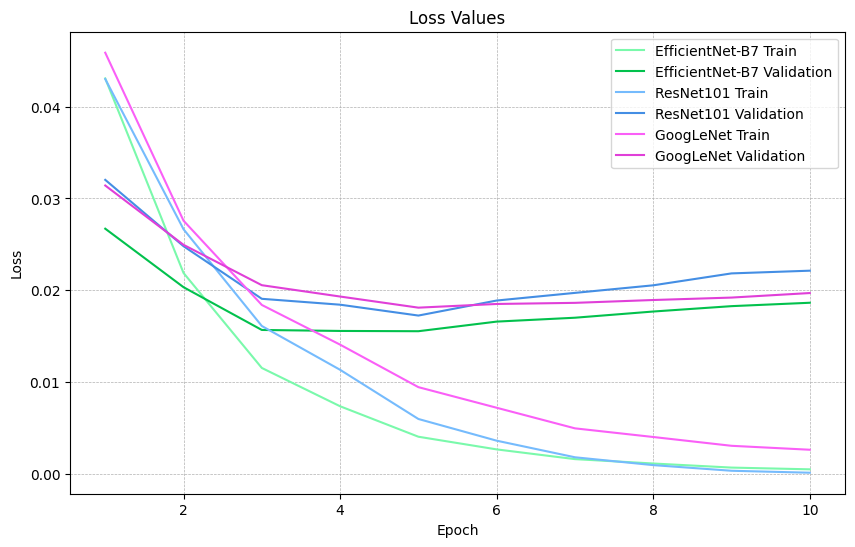

In [40]:
# Loss plot
plt.figure(figsize = (10, 6)) 

plt.plot(x, EfficientNet_b7_outcomes.Train_Loss, c = 'xkcd:seafoam green')
plt.plot(x, EfficientNet_b7_outcomes.Validation_Loss, c = 'xkcd:shamrock green')

plt.plot(x, ResNet101_outcomes.Train_Loss, c = 'xkcd:sky blue')
plt.plot(x, ResNet101_outcomes.Validation_Loss, c = 'xkcd:dark sky blue')

plt.plot(x, GoogLeNet_outcomes.Train_Loss, c = 'xkcd:light magenta')
plt.plot(x, GoogLeNet_outcomes.Validation_Loss, c = 'xkcd:purple pink')

plt.legend(['EfficientNet-B7 Train','EfficientNet-B7 Validation','ResNet101 Train','ResNet101 Validation',
           'GoogLeNet Train','GoogLeNet Validation'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss Values")
plt.grid(linestyle = "--", linewidth = 0.5)

plt.show()

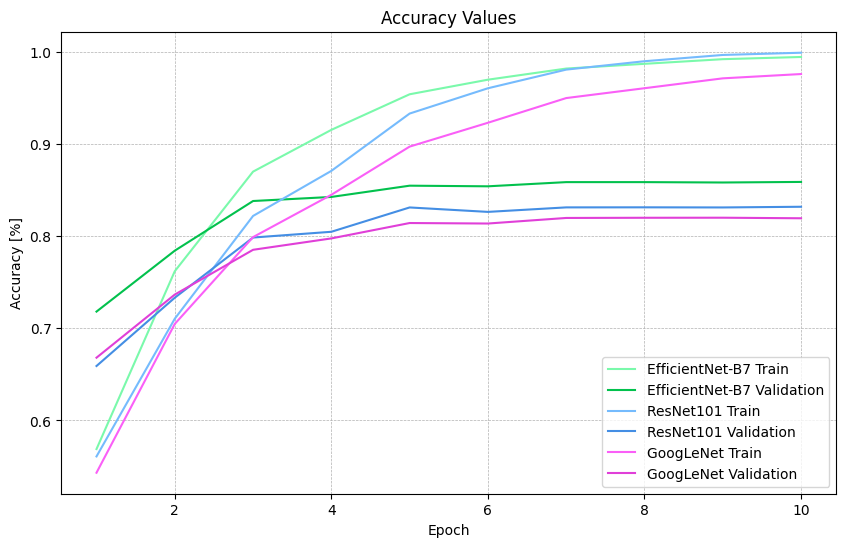

In [42]:
# Accuracy plot
plt.figure(figsize = (10, 6))

plt.plot(x, EfficientNet_b7_outcomes.Train_Accuracy, c = 'xkcd:seafoam green')
plt.plot(x, EfficientNet_b7_outcomes.Validation_Accuracy, c = 'xkcd:shamrock green')

plt.plot(x, ResNet101_outcomes.Train_Accuracy, c = 'xkcd:sky blue')
plt.plot(x, ResNet101_outcomes.Validation_Accuracy, c = 'xkcd:dark sky blue')

plt.plot(x, GoogLeNet_outcomes.Train_Accuracy, c = 'xkcd:light magenta')
plt.plot(x, GoogLeNet_outcomes.Validation_Accuracy, c = 'xkcd:purple pink')

plt.legend(['EfficientNet-B7 Train','EfficientNet-B7 Validation','ResNet101 Train','ResNet101 Validation',
           'GoogLeNet Train','GoogLeNet Validation'])

plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.title("Accuracy Values")
plt.grid(linestyle = "--", linewidth = 0.5)

plt.show()

## __Evaluation Metrics__

In [34]:
# Load the DataFrame from the CSV file
evaluation_models = pd.read_csv('evaluation_models.csv')

In [35]:
evaluation_models

model_name  accuracy  f1_score  average_precision  macro-averaging
0  EfficientNet_b7  0.858840  0.792597           0.656084         0.798234
1        ResNet101  0.832021  0.744560           0.586487         0.751232
2        GoogLeNet  0.820071  0.720867           0.563012         0.727557

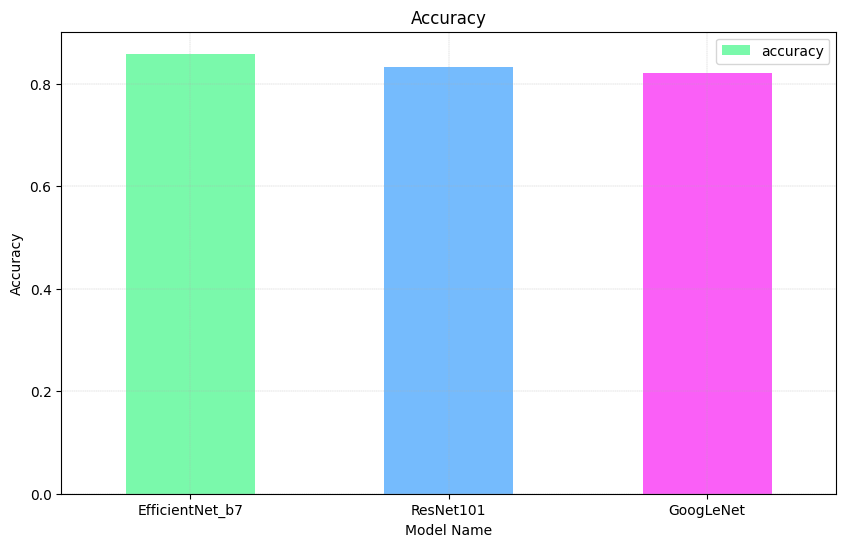

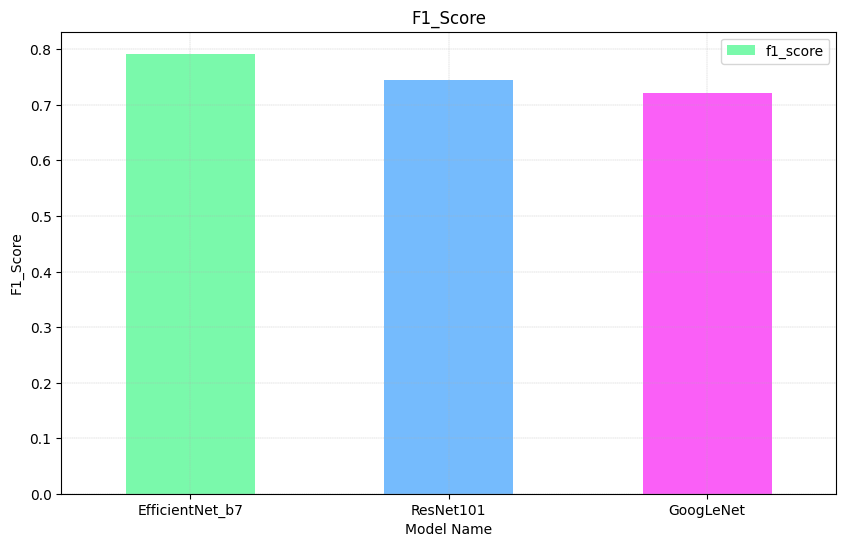

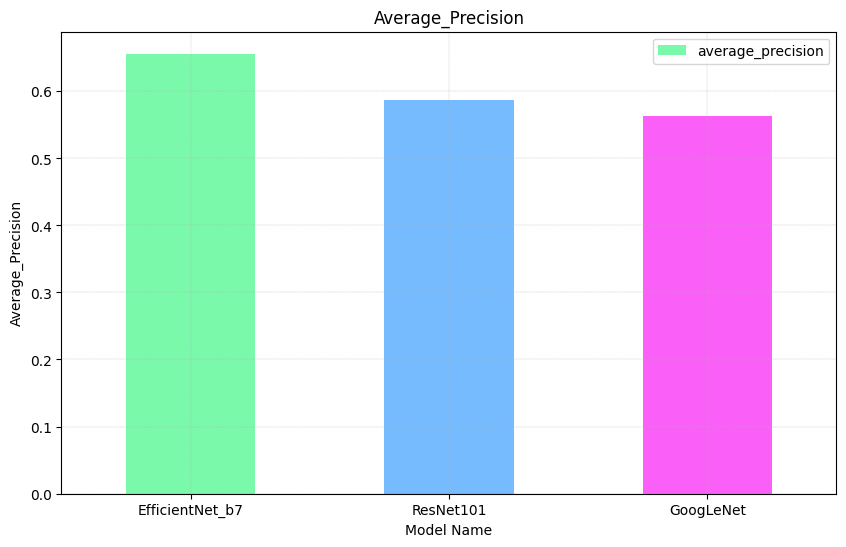

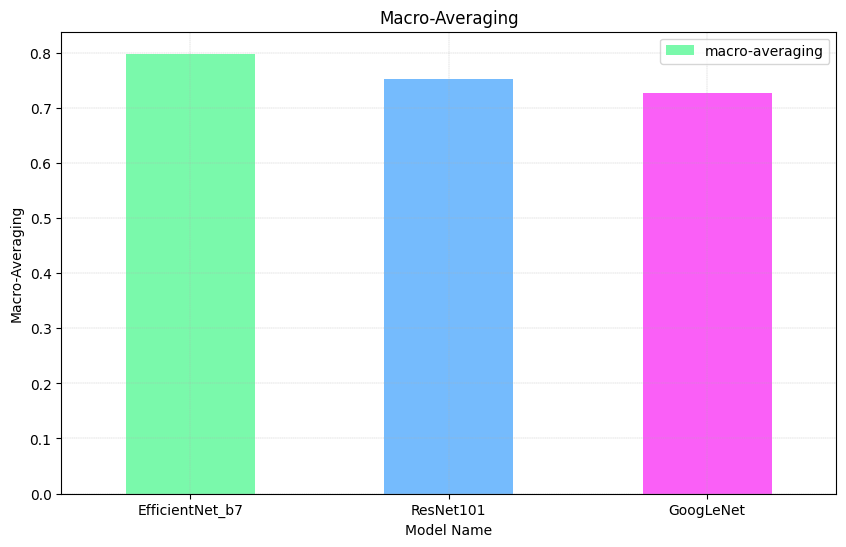

In [43]:
# Plot bar chart for each column
for column in evaluation_models.columns[1:]:
    evaluation_models.plot.bar(x = 'model_name', y = column, color = ['xkcd:seafoam green', 'xkcd:sky blue', 'xkcd:light magenta'], rot = 0, figsize = (10, 6))
    plt.title(column.title())
    plt.xlabel('Model Name')
    plt.ylabel(column.title())
    plt.grid(linestyle = "--", linewidth = 0.25)
    plt.show()

# __Report on ResearchGate__

https://www.researchgate.net/publication/370685912_Listen_to_the_Birds_A_Convolutional_Neural_Network_Approach_for_Bird_Species_Identification

# __References__

* Datasets & DataLoaders : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

* Audio Deep Learning Made Simple: Sound Classification, Step-by-Step : https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

* Saving/Loading your model in PyTorch : https://www.kaggle.com/getting-started/76343* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5